In [1]:
import numpy as np

from robust_smc.data import ConstantVelocityModel
from robust_smc.kalman import Kalman
from robust_smc.sampler import LinearGaussianBPF, RobustifiedLinearGaussianBPF


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Matplotlib settings
from cycler import cycler
import matplotlib as mpl

palette = cycler(color=mpl.cm.Set1.colors)
mpl.rc('axes', prop_cycle=palette)
mpl.rc('lines', lw=2)
mpl.rc('axes', lw=1.2, titlesize='x-large', labelsize='x-large')
mpl.rc('legend', fontsize='x-large')

In [3]:
plot_titles = [
    r'Displacement in $x$ direction',
    r'Displacement in $y$ direction',
    r'Velocity in $x$ direction',
    r'Velocity in $y$ direction'
]

In [4]:
observation_cov = 1.0 * np.eye(2)
contamination_probability = 0.1
simulator = ConstantVelocityModel(100, time_step=0.1, observation_cov=observation_cov, 
                                  explosion_scale=100.0, contamination_probability=contamination_probability)

In [5]:
kalman = Kalman(
    data=simulator.Y,
    transition_matrix=simulator.transition_matrix, 
    observation_matrix=simulator.observation_matrix,
    transition_cov=simulator.process_cov,
    observation_cov=simulator.observation_cov,
    m_0=np.zeros((4, 1)),
    P_0=simulator.initial_cov
)
kalman.filter()
filter_means = np.stack(kalman.filter_means)
filter_covs = np.stack(kalman.filter_covs)
filter_vars = np.diagonal(filter_covs, axis1=1, axis2=2)

In [6]:
X_init = simulator.initial_state[None, ...] + np.linalg.cholesky(simulator.initial_cov) @ np.random.randn(1000, 4, 1)
X_init = X_init.squeeze()

In [7]:
vanilla_bpf = LinearGaussianBPF(
    data=simulator.Y,
    transition_matrix=simulator.transition_matrix, 
    observation_model=lambda x :(simulator.observation_matrix @ x[:, :, None]).squeeze(),
    transition_cov=simulator.process_cov,
    observation_cov=np.diag(simulator.observation_cov),
    X_init=X_init,
    num_samples=1000
)
vanilla_bpf.sample()

In [8]:
robust_bpf = RobustifiedLinearGaussianBPF(
    data=simulator.Y,
    beta=0.01,
    transition_matrix=simulator.transition_matrix, 
    observation_model=lambda x :(simulator.observation_matrix @ x[:, :, None]).squeeze(),
    transition_cov=simulator.process_cov,
    observation_cov=np.diag(simulator.observation_cov),
    X_init=X_init,
    num_samples=1000
)
robust_bpf.sample()

In [9]:
def get_means_and_quantiles(sampler, state):
    trajectories = np.stack(sampler.X_trajectories)
    means = trajectories[:, :, state].mean(axis=1)
    quantiles = np.quantile(trajectories[:, :, state], q=[0.05, 0.95], axis=1)
    return means, quantiles

In [18]:
def plot_state(state, figsize, zoom=False, save_file=None):
    X = np.arange(0, 100, 0.1)
    plt.figure(figsize=figsize)
    plt.plot(X, simulator.X[:, state], label='Ground Truth', color='k', alpha=0.8)
    
    # Kalman
    means = filter_means[:, state].squeeze()
    uncertainties = np.sqrt(filter_vars[:, state]).squeeze()
    plt.plot(X, means, color='C2', ls=':', label='Kalman Filter')
    plt.fill_between(X, means - 1.64 * uncertainties, means + 1.64 * uncertainties, color='C2', alpha=0.6)
    
    # BPF
    means, quantiles = get_means_and_quantiles(vanilla_bpf, state)
    plt.plot(X, means, color='C1', ls='--', label='BPF')
    plt.fill_between(X, quantiles[0, :], quantiles[1, :], color='C1', alpha=0.6)
    
    
    # Robust BPF
    means, quantiles = get_means_and_quantiles(robust_bpf, state)
    plt.plot(X, means, color='C0', ls='-.', label=r'$\beta$-BPF')
    plt.fill_between(X, quantiles[0, :], quantiles[1, :], color='C0', alpha=0.6)
    
    if zoom:
        y_min = quantiles[0, :].min()
        y_max = quantiles[1, :].max()
        
        y_min = 1.2 * y_min if y_min < 0 else 0.8 * y_min
        y_max = 1.2 * y_max if y_max > 0 else 0.8 * y_max
        
        plt.ylim((y_min, y_max))
        
    if state < 2:
        plt.ylabel(r'metres')
    else:
        plt.ylabel(r'metres per second')
        
#     plt.xlabel('time')
    plt.title(plot_titles[state], fontsize='x-large')
    
    plt.legend(loc='lower center', frameon=False, bbox_to_anchor=(0.5, -0.4), ncol=4, fontsize='large')
    plt.savefig(f'./figures/paper_figures/constant-velocity/latent_variable_plots_{state}.pdf', 
                bbox_inches='tight')

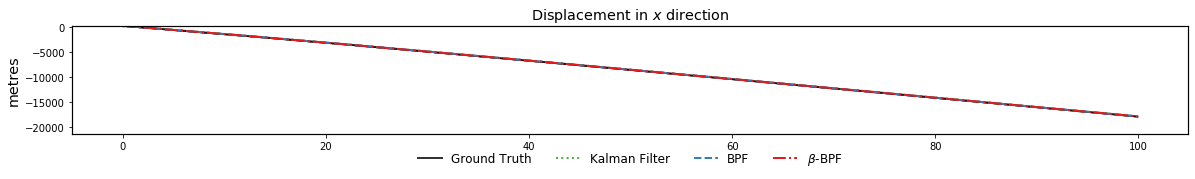

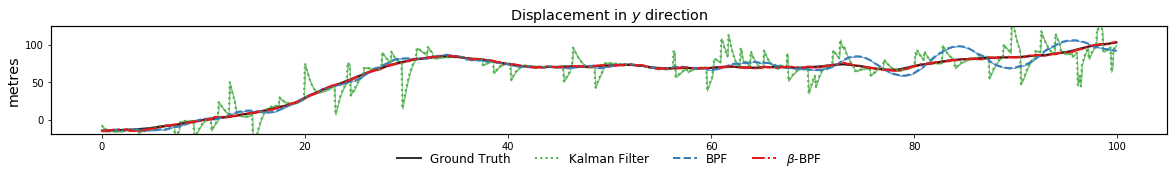

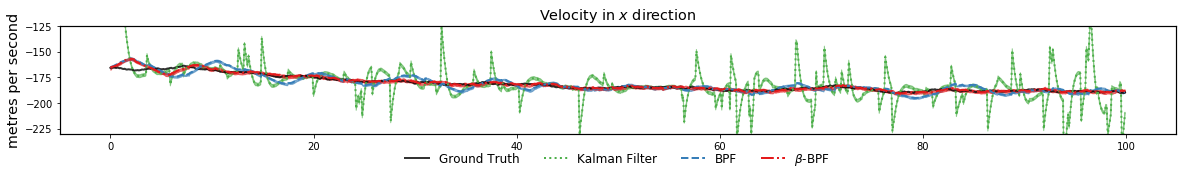

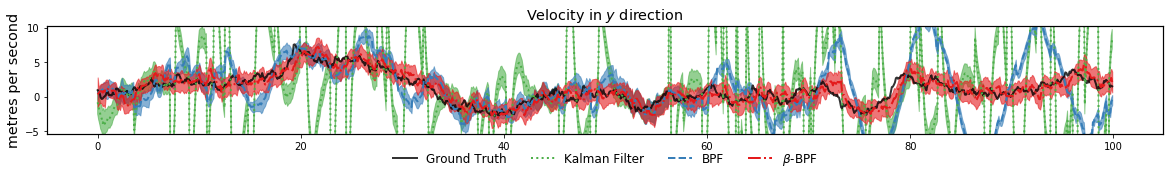

In [19]:
for state in range(4):
    plot_state(state, figsize=(20, 2), zoom=True)

Text(0.5, 1.0, 'Robustified BPF')

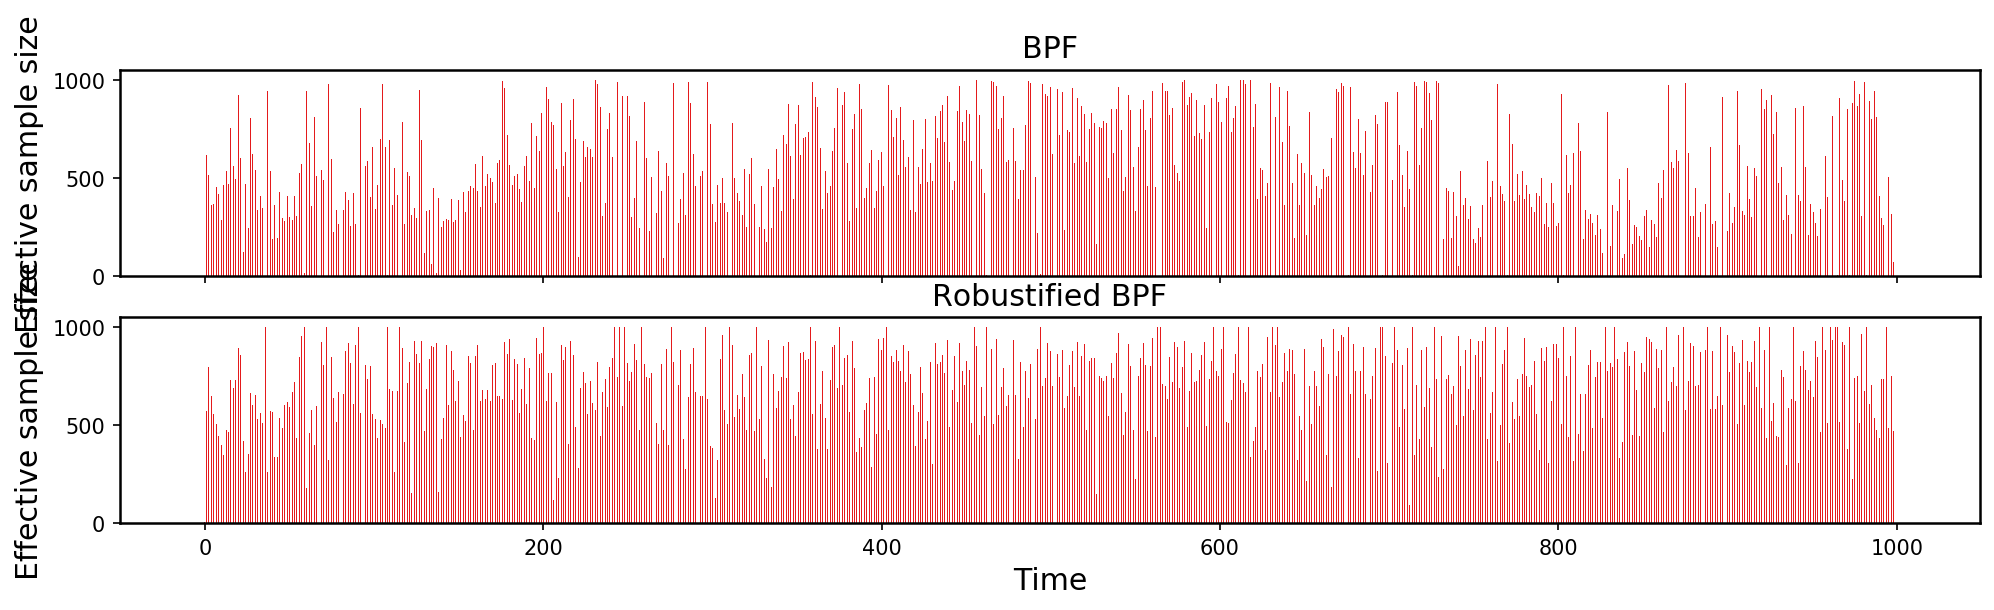

In [14]:
vanilla_bpf_ess = [vanilla_bpf.effective_sample_size(logw) for logw in vanilla_bpf.logw]
robust_bpf_ess = [robust_bpf.effective_sample_size(logw) for logw in robust_bpf.logw]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 4), dpi=150, sharex=True)

ax[0].bar(range(len(vanilla_bpf_ess)), vanilla_bpf_ess, width=0.4)
ax[0].set_title('BPF')
ax[0].set_ylabel('Effective sample size')
ax[1].bar(range(len(robust_bpf_ess)), robust_bpf_ess, width=0.4)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Effective sample size')
ax[1].set_title('Robustified BPF')

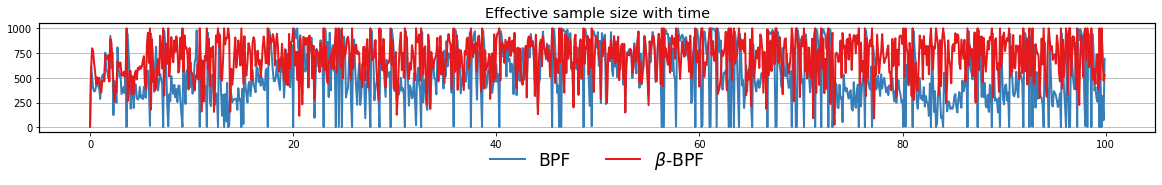

In [20]:
vanilla_bpf_ess = [vanilla_bpf.effective_sample_size(logw) for logw in vanilla_bpf.logw]
robust_bpf_ess = [robust_bpf.effective_sample_size(logw) for logw in robust_bpf.logw]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 2), sharex=True)

X = np.arange(0, 100, 0.1)
ax.plot(X, vanilla_bpf_ess, label='BPF', c='C1')
ax.plot(X, robust_bpf_ess, label=r'$\beta$-BPF', c='C0')
ax.grid(axis='y')
# ax.set_xlabel('time')
ax.set_title('Effective sample size with time', fontsize='x-large')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=2, fontsize='xx-large', frameon=False);

plt.savefig('./figures/paper_figures/constant-velocity/effecive_sample_size.pdf', bbox_inches='tight')